In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

import sys
sys.path.append('../')

Jax is using: gpu


# Simulate data

In [3]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


In [4]:
# define spatial parameters
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

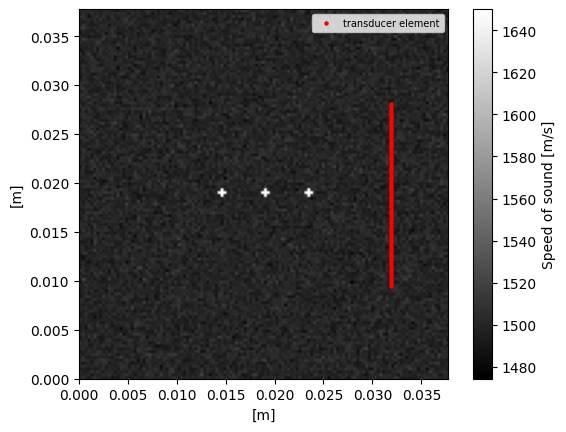

In [5]:
from jwave_utils import get_domain, get_point_medium, get_homogeneous_medium

# define jwave medium
medium_params = {
    'c0': 1500,  # speed of sound [m/s]
    'rho0': 1000,  # density [kg/m^3]
    'background_mean': 1,  # mean of the background noise
    'pml_size': pml[0]  # size of the perfectly matched layer [grid points]
}

domain = get_domain(N, dx)
speed_homogenous, density_homogenous = get_homogeneous_medium(domain, **medium_params, background_std=0, background_seed=29)

scatterer_positions = np.array([[domain.N[0]//2, domain.N[1]//2 + 15],
                                [domain.N[0]//2, domain.N[1]//2],
                                [domain.N[0]//2, domain.N[1]//2 - 15]], dtype=int)
speed, density = get_point_medium(domain, scatterer_positions, **medium_params, background_std = 0.004, scatterer_radius=1, scatterer_contrast=1.1, background_seed=28)

ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(speed, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

2024-08-11 19:03:30.438670: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


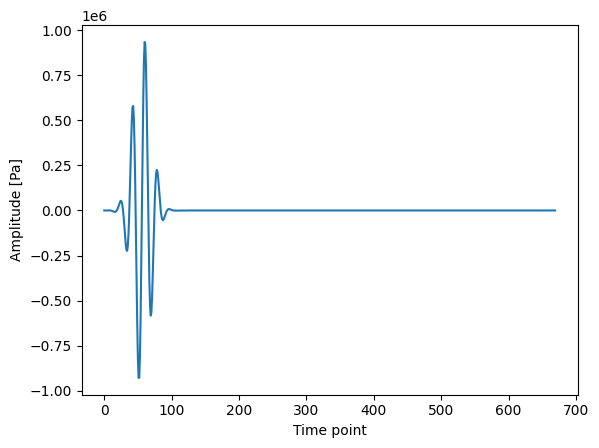

In [6]:
from jwave.geometry import TimeAxis
from jwave.geometry import Medium
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
time_axis = TimeAxis.from_medium(Medium(domain, speed, density, pml_size=pml[0]), cfl=0.3)
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)

plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [7]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(speed, density, domain, time_axis, sources, element_positions)
_, data_homogenous = get_data(speed_homogenous, density_homogenous, domain, time_axis, sources, element_positions)

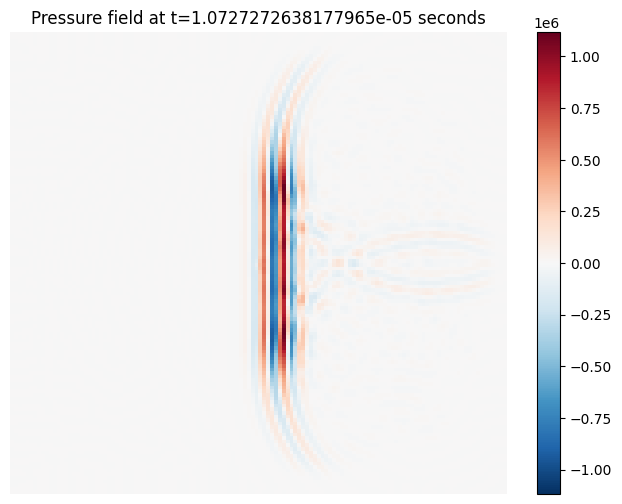

In [8]:
from jwave.utils import show_field

t_idx = 200
show_field(pressure[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

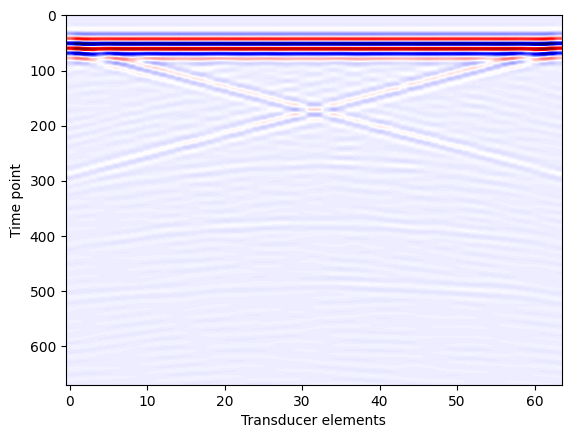

In [9]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

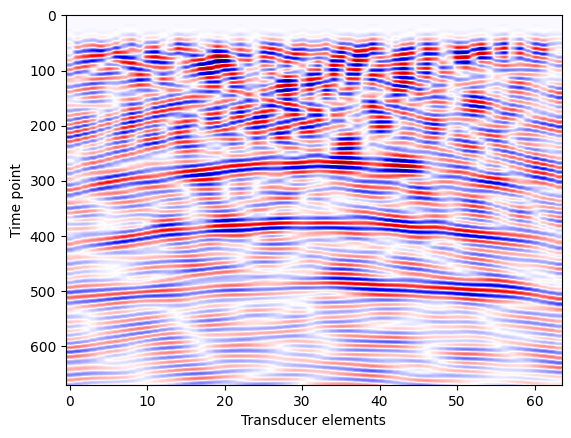

In [10]:
output_data = data-data_homogenous
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Reconstruction

## Single angle

In [11]:
from beamforming_utils import get_receive_beamforming
res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

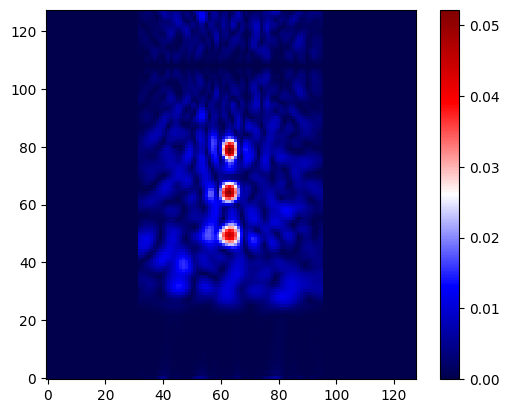

In [13]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(orig_res):
    result = np.copy(orig_res)
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    return np.flipud(result).T

bmode=postprocess_result(res)
plt.imshow(bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Multiple angles

In [13]:
signal_delays = np.linspace(-0.5, 0.5, 10)
results = []
for signal_delay in signal_delays:
    print(f"Signal delay: {signal_delay}")
    sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)
    _, data = get_data(speed, density, domain, time_axis, sources, element_positions)
    _, data_homogenous = get_data(speed_homogenous, density_homogenous, domain, time_axis, sources, element_positions)
    output_data = data-data_homogenous
    res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
    results.append(res)

Signal delay: -0.5
Signal delay: -0.3888888888888889
Signal delay: -0.2777777777777778
Signal delay: -0.16666666666666669
Signal delay: -0.05555555555555558
Signal delay: 0.05555555555555558
Signal delay: 0.16666666666666663
Signal delay: 0.2777777777777777
Signal delay: 0.38888888888888884
Signal delay: 0.5


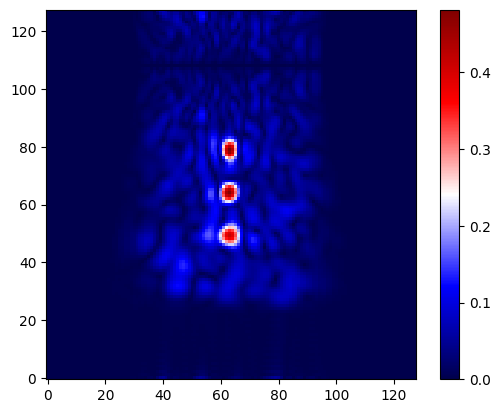

In [14]:
compounded_res = np.sum(results, axis=0)
compounded_bmode=postprocess_result(compounded_res)
# bmodes = [postprocess_result(res) for res in results]
# compounded_bmode = np.sum(bmodes, axis=0)

plt.imshow(compounded_bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Gradient

In [25]:
from jax import value_and_grad
from jwave_utils import get_data_only

ntimepoints, nelements = output_data.shape
params = speed

@jit
def linear_loss(speed, J, dy):
    loss = jnp.linalg.norm(dy - (J @ (speed - speed_homogenous).flatten()).reshape((ntimepoints, nelements)), ord='fro')
    return loss
# @jit
# def linear_loss(x, A, b):
#     Ax = jnp.tensordot(A, x, axes=([0, 1, 2], [0, 1, 2]))
#     return jnp.sum((Ax - b) ** 2)
linear_val_and_grad = value_and_grad(linear_loss, argnums=0)

@jit
def nonlinear_loss(speed):
    predicted = get_data_only(speed, density_homogenous, domain, time_axis, sources, element_positions)
    observed = data_homogenous
    loss = jnp.linalg.norm(observed - predicted, ord='fro')
    return loss
nonlinear_val_and_grad = value_and_grad(nonlinear_loss, argnums=0)

In [ ]:
# compute first linear gradient
J = jax.jacrev(get_data_only, argnums=0)(jnp.array(speed), density_homogenous, domain, time_axis, sources, element_positions)
linear_loss, linear_gradient = linear_val_and_grad(params, J, output_data)
print(f"Linear loss: {linear_loss}")

In [17]:
# compute first nonlinear gradient
nonlinear_loss, nonlinear_gradient = nonlinear_val_and_grad(params)
print(f"Nonlinear loss: {nonlinear_loss}")

Nonlinear loss: 1074841.5


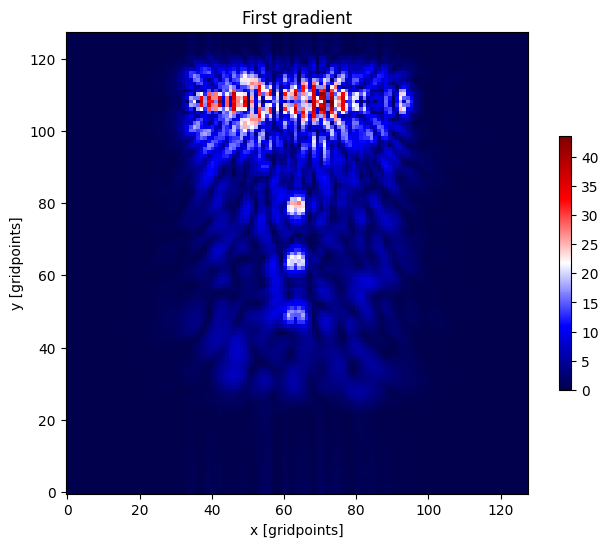

In [21]:
# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(postprocess_result(nonlinear_gradient), cmap='seismic')
plt.title("First gradient")
plt.xlabel('x [gridpoints]')
plt.ylabel('y [gridpoints]')
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.55)
plt.show()